In [3]:
from PIL import Image
import numpy as np
import os
from glob import glob
import cv2
import shutil
import keras
from tqdm import tqdm
from datetime import datetime
from nets import Hairnet
import math
import dlib
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, History, EarlyStopping, CSVLogger, LearningRateScheduler
from keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
def adjustData(img, mask, flag_multi_class, num_class):
    if flag_multi_class:
        img = img / 255
        mask = mask[:, :, :, 0] if (len(mask.shape) == 4) else mask[:, :, 0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            # for one pixel in the image, find the class in mask and convert it into one-hot vector
            # index = np.where(mask == i)
            # index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            # new_mask[index_mask] = 1
            new_mask[mask == i, i] = 1
        new_mask = np.reshape(new_mask, (new_mask.shape[0], new_mask.shape[1] * new_mask.shape[2],
                                         new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask, (
            new_mask.shape[0] * new_mask.shape[1], new_mask.shape[2]))
        mask = new_mask
    elif np.max(img) > 1:
        img = img / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return img, mask

In [5]:
batch_size = 30

def dataGenerator(path):
    gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

    image_datagen = ImageDataGenerator(gen_args)
    mask_datagen = ImageDataGenerator(gen_args)

    train_path = './Image/'

    # 학습 데이터 제너레이터
    image_generator = image_datagen.flow_from_directory(
        train_path+path,
        classes=['original'],
        class_mode=None,
        color_mode='rgb',
        target_size=(224, 224),
        batch_size=30,
        save_to_dir=None,
        save_prefix='image',
        seed=1
    )

    mask_generator = mask_datagen.flow_from_directory(
        train_path+path,
        classes=['mask'],
        class_mode=None,
        color_mode='grayscale',
        target_size=(224, 224),
        batch_size=30,
        save_to_dir=None,
        save_prefix='mask',
        seed=1
    )

    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = adjustData(img, mask, False, 2)
        yield (img, mask)

In [6]:
def get_data():
    train_data = dataGenerator(path = 'train')
    val_data = dataGenerator(path = 'test')
    
    return train_data, val_data

In [7]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [8]:
def getCallback(path):
    model_checkpoint = ModelCheckpoint(os.path.join(path, 'checkpoint.h5'), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
    csv_logger = CSVLogger(os.path.join(path, "model_history_log.csv"), append=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
    
    lrate = LearningRateScheduler(step_decay)
    
    return [model_checkpoint, early_stop, csv_logger]

In [9]:
# model = Hairnet.get_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 30
epochs = 100
data_size = len(os.listdir(f"./Image/train/original"))
steps_per_epoch = data_size // batch_size

current = datetime.now()
path_model = f'./save_model/{current.strftime("%m-%d-%Y_%H-%M-%S")}'
    
if not os.path.exists(path_model):
    os.makedirs(path_model)
    
train_data, val_data = get_data()
# callbacks = getCallback(path = path_model)

model_checkpoint = ModelCheckpoint(os.path.join(path_model, 'checkpoint.h5'), monitor='val_loss', verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_model, "model_history_log.csv"), append=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

history = model.fit(train_data, callbacks=[model_checkpoint, csv_logger, early_stop], steps_per_epoch= steps_per_epoch, epochs=epochs, validation_data=val_data, validation_steps=50)

NameError: name 'model' is not defined

In [18]:
# 히스토리 객체를 DataFrame으로 변환
history_df = pd.DataFrame(history.history)
# CSV 파일로 저장
history_df.to_csv(os.path.join(path_model, "model_history.csv"), index=False)

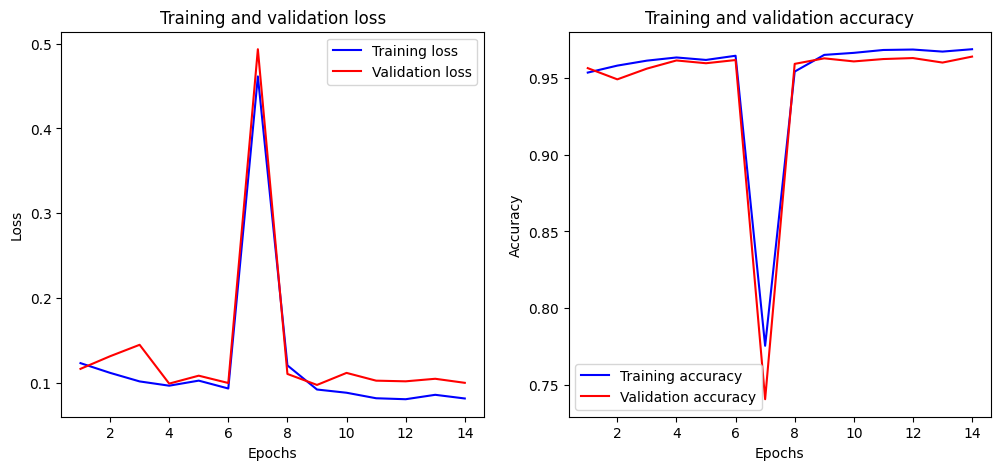

In [21]:
def plot_history(history):
    # 손실 값 추출
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # 정확도 추출
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # 그래프 그리기
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# history 객체를 이용하여 그래프 그리기
plot_history(history)

In [30]:
def getHead(hog_face_detector, image):
    faces_hog = hog_face_detector(image, 1)

    heads = []
    
    for face in faces_hog:
        
        head = dict()
        
        head["left"] = max(face.left() - 300, 0)
        head["top"] = max(face.top() - 300, 0)
        head["right"] = min(face.right() + 300, image.shape[0])
        head["bottom"] = min(face.bottom() + 300, image.shape[1])
        
        heads.append(head)

    return heads

In [ ]:
hog_face_detector = dlib.get_frontal_face_detector()



In [8]:
old_model = './model.pth'